# Data generation

This notebook simulates some kind of T2* Ramsey characterization although we ommited the pulsing for simplicity.

## Imports

In [6]:
import pathlib

import numpy as np
import pandas as pd
import xarray as xr

# mostly tuse qutip o add more complex dependencies 
# It's not a necessity to do the ramsey experiment 
from qutip import mesolve, Options, basis, sigmax, sigmay, sigmaz, Qobj

from matplotlib import pyplot as plt

data_dir = pathlib.Path("data")
data_dir.mkdir(exist_ok=True)

# Create T2 Dataset with noise

In [2]:
n_calib = 5
times = np.linspace(0.0, 25.0, 250)

# system properties
detuning = 0.2
T2 = 5
offset = 0.2
scale = 0.5
noise_sigma = 0.02
rng = np.random.default_rng(seed=42)

hadamard = 1 / np.sqrt(2.0) * Qobj([[1, 1],
                                    [1, -1]])

psi0 = basis(2, 0)
# initialize to Hadamard |0> = |+> = |0> + |1>
psi_plus = hadamard @ psi0

# hamiltonian
H = 2*np.pi * detuning * sigmaz()

# meas operator
e_op = psi_plus @ psi_plus.dag()

result = mesolve(H, psi_plus, times,
                 # collapse operator 
                 c_ops=[np.sqrt(1/T2) * sigmax()],
                 # operator for expectation value
                 e_ops=[e_op])

# Get probability data.
P_1, = result.expect

# add calibration points
clean_signal = P_1 * scale + offset
clean_calib_0 = np.ones(n_calib) * offset
clean_calib_1 = offset + scale * np.ones(n_calib)

# add white noise
raw_signal = clean_signal + rng.normal(0, noise_sigma, clean_signal.size)
calib_0 = clean_calib_0 + rng.normal(0, noise_sigma, clean_calib_0.size)
calib_1 = clean_calib_1 + rng.normal(0, noise_sigma, clean_calib_1.size)

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\janka\AppData\Local\Temp\ipykernel_7724\4293506005.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('t ($\mathrm{\mu}$s)')


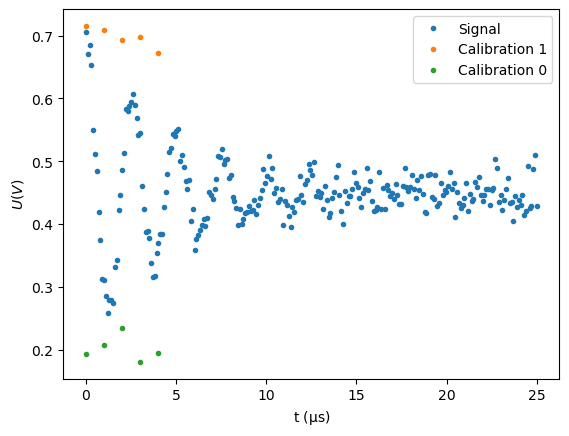

In [3]:
# plot signal and calibration for debugging

fig, ax = plt.subplots()
ax.plot(times, raw_signal, ".", label="Signal")
plt.xlabel('t ($\mathrm{\mu}$s)')
plt.ylabel('$U (V)$')

ax.plot(calib_1, ".", label="Calibration 1")
ax.plot(calib_0, ".", label="Calibration 0")
plt.legend()

# Save csv file via pandas

CSV does not allow attaching metadata so we would need to hack our calibration into the file or create a separate one.

In [7]:
dataframe = pd.DataFrame()

csv_times = np.concatenate([times, np.full(10, np.nan)])
csv_U = np.concatenate([raw_signal, calib_1, calib_0])

dataframe['time [us]'] = csv_times
dataframe['U [V]'] = csv_U

dataframe.to_csv(data_dir/ 'P_one_vs_time.csv', encoding='utf-8', header=True, index=False)


# Save to netCDF via xarray

In [8]:
nc_U = xr.Variable(
    data=raw_signal,
    dims=('time [us]',),
    attrs={
        'calib_1 [V]': calib_1,
        'calib_0 [V]': calib_0,
    }
)

dataset = xr.Dataset(
    {
        'U [V]': nc_U
    },
    coords={'time [us]': times},
    attrs={
        'comment': "Ramsey T2* experiment. Each voltage curve has callibration measurements for 0 and 1 probability."
    }
)

dataset.to_netcdf(data_dir / 'P_one_vs_time.nc')